# Gridworld Markov Decision Process (MDP)

We consider a finite **Gridworld MDP** with:

- Finite state space $\mathcal{S}$
- Finite action space $\mathcal{A}$
- Stochastic transition probabilities
- Discount factor $\gamma \in (0,1)$

### State Space Partitioning

* Full State Space ($\mathcal{S}$): $\{(i, j) : 0 \le i, j < N\}$
* Terminal States ($\mathcal{T}$): $\{R_1, R_2\}$
* Non-Terminal States ($\mathcal{S} \setminus \mathcal{T}$): $\{s \in \mathcal{S} \mid s \notin \mathcal{T}\}$



### Reward Model

The reward is defined solely by the source state $s$ within the non-terminal domain:

$$R: (\mathcal{S} \setminus \mathcal{T}) \rightarrow \mathbb{R}$$

For any $s \in (\mathcal{S} \setminus \mathcal{T})$:

$$R(s) = \left\lfloor \frac{N}{2} \right\rfloor - \text{col}(s)$$

### Bellman Equations with Dirichlet Boundary Conditions

Terminal states are treated as fixed values (prizes) and are excluded from the update operators:

**Boundary Condition:**
$$v(s) = \text{Prize}_s, \quad \forall s \in \mathcal{T}$$

In [301]:
# Grid size
N = 5

# States as (row, col)
states = [(i, j) for i in range(N) for j in range(N)]

# Actions
actions = ['U', 'D', 'L', 'R']

# Discount Factor
gamma = 0.95

# Terminal states
R1 = (0, 0)   # top-left
R2 = (0, 4)   # top-right
terminal_states = {R1, R2}

def immediate_reward():
    """R contains ONLY step rewards. Terminal prizes are handled as boundary conditions."""
    R = {}
    middle_col = N // 2
    for s in states:
        R[s] = {}
        for s_next in states:
            if s not in terminal_states:
                R[s][s_next] = middle_col - s[1]
            else:
                R[s][s_next] = 0.0
    return R

### Gridworld Visualization
Displays the state values, rewards, and policy arrows on the gridworld. Terminal states are highlighted in red.


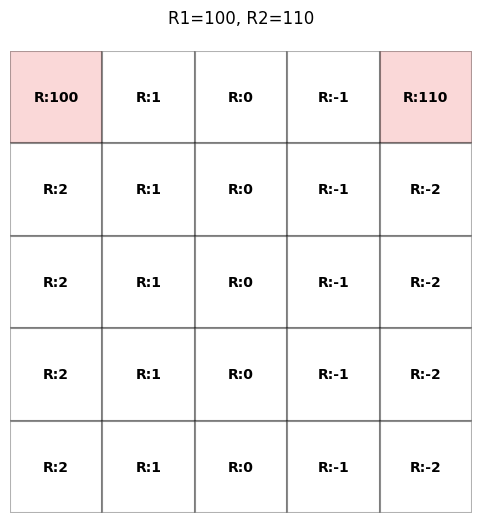

In [302]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gridworld(R_dict, V=None, policy=None, title="Gridworld", R1_val=100, R2_val=110):
    fig, ax = plt.subplots(figsize=(6, 6))
    arrow_map = {'U': (0, 0.4), 'D': (0, -0.4), 'L': (-0.4, 0), 'R': (0.4, 0)}
    
    for (i, j) in states:
        x, y = j, N - 1 - i
        
        color = 'lightcoral' if (i, j) in terminal_states else 'white'
        rect = plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.3)
        ax.add_patch(rect)
        
        # Determine Reward for this cell
        if (i, j) == R1:
            cell_reward = R1_val
        elif (i, j) == R2:
            cell_reward = R2_val
        else:
            cell_reward = R_dict[(i, j)].get((i, j), (N//2 - j))

        # 3. Text Logic
        if V is not None:
            # Show Value (V) in center
            ax.text(x + 0.5, y + 0.5, f"{V[(i, j)]:.1f}", ha='center', va='center', 
                    fontsize=10, fontweight='bold')
            # Show Reward (R in corner
            ax.text(x + 0.05, y + 0.95, f"R:{cell_reward:g}", ha='left', va='top', 
                    fontsize=7, color='gray')
        else:
            # No Value given: Show Reward in center
            ax.text(x + 0.5, y + 0.5, f"R:{cell_reward:g}", ha='center', va='center', 
                    fontsize=10, fontweight='bold')
        
        # 4. Policy Arrows
        if policy and (i, j) not in terminal_states:
            dx, dy = arrow_map.get(policy[(i, j)], (0, 0))
            ax.arrow(x + 0.5, y + 0.5, dx, dy, head_width=0.15, head_length=0.15, 
                     fc='blue', ec='blue', alpha=0.7)
    
    ax.set_xlim(0, N); ax.set_ylim(0, N); ax.set_aspect('equal')
    ax.set_title(title, pad=20); ax.axis('off')
    plt.show()

# Example usage:
R_static = immediate_reward()
R1_val = 100
R2_val = 110
plot_gridworld(R_static, title=f"R1={R1_val}, R2={R2_val}", R1_val=R1_val, R2_val=R2_val)

## State Transitions

Actions are **noisy**: the intended action succeeds with probability $0.7$, and the remaining probability is split among other actions.

Walls cause the agent to remain in the same state.

In [303]:
def move(s, a):
    i, j = s
    if a == 'U':
        s_new = (i - 1, j)
    elif a == 'D':
        s_new = (i + 1, j)
    elif a == 'L':
        s_new = (i, j - 1)
    elif a == 'R':
        s_new = (i, j + 1)
    else:
        raise ValueError("Invalid action")

    # Wall collision → no movement
    if s_new[0] < 0 or s_new[0] >= N or s_new[1] < 0 or s_new[1] >= N:
        return s

    return s_new

### Action Noise Model

Each intended action $a$ results in a distribution over actual actions.

In [304]:
action_noise = {
    'U': {'U': 0.7, 'D': 0.1, 'L': 0.1, 'R': 0.1},
    'D': {'D': 0.7, 'U': 0.1, 'L': 0.1, 'R': 0.1},
    'R': {'R': 0.7, 'L': 0.1, 'U': 0.1, 'D': 0.1},
    'L': {'L': 0.7, 'R': 0.1, 'U': 0.1, 'D': 0.1},
}

## Transition Probability Kernel

We construct the transition kernel:

$$
P(S_{t+1}=s' \mid S_t=s, A_t=a)
$$

Terminal states are **absorbing**.

In [305]:
P = {}

for s in states:
    P[s] = {}

    # Terminal states are absorbing
    if s in terminal_states:
        for a in actions:
            P[s][a] = {s: 1.0}
        continue

    for a in actions:
        P[s][a] = {}

        for actual_action, prob in action_noise[a].items():
            s_next = move(s, actual_action)

            # Sum probabilities if multiple actual actions lead to the same next state
            if s_next in P[s][a]:
                P[s][a][s_next] += prob
            else:
                P[s][a][s_next] = prob

## Value Functions

### State-value function

The **state-value function** under policy $\pi$ is defined as the expected return starting from state $s$:

$$
v_\pi(s) = \mathbb{E}_\pi \Big[ G_t \mid S_t = s \Big] = \sum_{a} \pi(a \mid s) \sum_{s'} P(s' \mid s,a) \Big[ R(s,s') + \gamma v_\pi(s') \Big]
$$

### Action-value function

The **action-value function** under policy $\pi$ is defined as the expected return starting from state $s$ and taking action $a$:

$$
q_\pi(s,a) = \mathbb{E}_\pi \Big[ G_t \mid S_t = s, A_t = a \Big]= \sum_{s'} P(s' \mid s,a) \Big[ R(s,s') + \gamma \sum_{a'} \pi(a' \mid s') q_\pi(s',a') \Big]
$$

> **Note:** terminal states are fixed.$$v_\pi(s) = 
\begin{cases} 
\sum_{a} \pi(a \mid s) \sum_{s'} P(s' \mid s,a) \Big[ R(s,s') + \gamma v_\pi(s') \Big] & \text{if } s \notin \text{terminal\_states} \\
\text{Prize}_s & \text{if } s \in \text{terminal\_states}
\end{cases}$$

## Bellman Expectation Operator ($T^\pi$)

For a fixed policy $\pi$, the operator applied to the **vector of state-values** $V = [v(s_1), v(s_2), \dots, v(s_n)]^\top$ is:

$$
T^\pi V = R + \gamma \, P^\pi V
$$

where:

* $V$ is the vector of all state-values $v(s)$
* $R$ is the vector of immediate rewards $R(s,s')$
* $P^\pi$ is the **state-to-state transition matrix** under policy $\pi$, defined as:

$$
P^\pi_{s,s'} = \sum_a \pi(a \mid s) \, P(s' \mid s, a)
$$

For any single state $s \in \mathcal{S}_{nt}$:$$(T^\pi v)(s) = \sum_{a} \pi(a \mid s) \sum_{s'} P(s' \mid s,a) \Big[ R(s,s') + \gamma v(s') \Big]$$While for $s \in \mathcal{T}$:$$(T^\pi v)(s) = v(s) \quad \text{(Fixed Boundary Condition)}$$

In [306]:
def T_pi(V, states, P, R, policy, gamma=gamma):
    V_new = V.copy()
    Q = {}
    for s in states:
        if s in terminal_states:
            continue 
            
        a = policy[s]
        q_sa = 0.0
        for s_next, p in P[s][a].items():
            q_sa += p * (R[s][s_next] + gamma * V[s_next])
            
        V_new[s] = q_sa
        Q[s] = {a: q_sa}
    return V_new, Q

## Bellman Optimality Operator ($T^*$)

The **optimal value function** can be defined as the **maximum expected value over all policies**:

$$
v_*(s) = \max_\pi v_\pi(s) = \max_\pi \sum_a \pi(a \mid s) \, q_\pi(s,a)
$$

* If $\pi$ is deterministic, this reduces to a **max over actions**:

$$
v_*(s) = \max_a q_*(s,a)
$$

> **Remark:** In any finite MDP, there always exists at least one **deterministic optimal policy** $\pi_*$ that achieves $v_*(s)$ for all states.

The **optimal action-value function** is defined as:

$$
q_*(s,a) = \sum_{s'} P(s' \mid s,a) , \Big[ R(s,s') + \gamma \, v_*(s') \Big]
$$

The operator applied to the **vector of state-values** is:

$$
T^* V_* = R + \gamma \, \max_a P^a V_*
$$

where:

* $\max_a$ is **elementwise over states**
* $P^a$ is the **state-to-state transition matrix** when taking **action $a$**, defined as:

$$
P^a_{s,s'} = P(s' \mid s, a)
$$

For any single state $s \in \mathcal{S}$:

$$(T^* v)(s) = 
\begin{cases} 
\max_{a} \sum_{s'} P(s' \mid s,a) \Big[ R(s,s') + \gamma v(s') \Big] & \text{if } s \notin \mathcal{T} \\
v(s) & \text{if } s \in \mathcal{T}
\end{cases}$$

In [307]:
def T_opt(V, states, actions, P, R, gamma=gamma):
    V_new = V.copy()
    Q = {}
    for s in states:
        if s in terminal_states:
            continue 

        Q_s = {}
        for a in actions:
            q_sa = 0.0
            for s_next, p in P[s][a].items():
                q_sa += p * (R[s][s_next] + gamma * V[s_next])
            Q_s[a] = q_sa
            
        V_new[s] = max(Q_s.values())
        Q[s] = Q_s
    return V_new, Q

## Bellman Equations \& Fixed Points

The **Bellman equations** can be interpreted as **fixed-point equations** of their respective operators:

* **Bellman Expectation Equation:**

$$
V_\pi = T^\pi V_\pi = R + \gamma P^\pi V_\pi
$$

* **Bellman Optimality Equation:**

$$
V_* = T^* V_* = R + \gamma \max_a P^a V_*
$$

> **Key Idea:** Solving the Bellman equation is **simply finding the fixed point** of the corresponding operator.
> Any initial guess $V_0$ iteratively updated by the operator converges to this fixed point because the operators are **$\gamma$-contractions** according to the **Banach Fixed-Point Theorem**.

In [308]:
def solve_fixed_point(operator_func, states, initial_V=None, theta=1e-6, **kwargs):
    """Generic solver to find the fixed point of any Bellman operator."""
    V = initial_V if initial_V else {s: 0.0 for s in states}
    while True:
        V_new, Q = operator_func(V, states, **kwargs)
        delta = max(abs(V_new[s] - V[s]) for s in states)
        V = V_new
        if delta < theta:
            return V, Q

## Value Iteration
Iteratively update the value function using

$$
V_{k+1} = T^*(V_k)
$$

until convergence. After convergence, the **greedy deterministic policy** for each state is extracted as:

$$
\pi_*(a\mid s) =
\begin{cases}
1, & \text{if } a = \arg\max_{a'} q_*(s, a')\\[2mm]
0, & \text{otherwise}
\end{cases}
$$

We explore multiple reward settings to see how the optimal strategy changes.

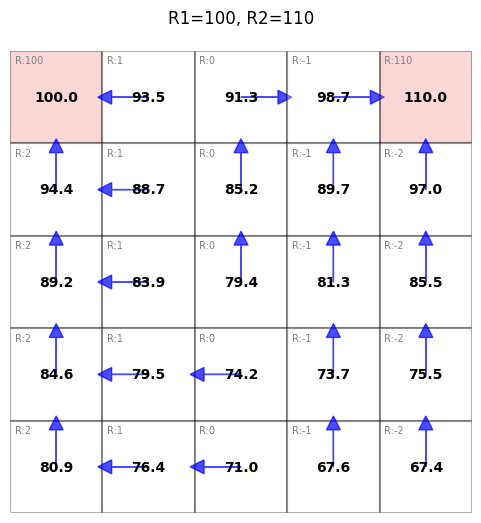

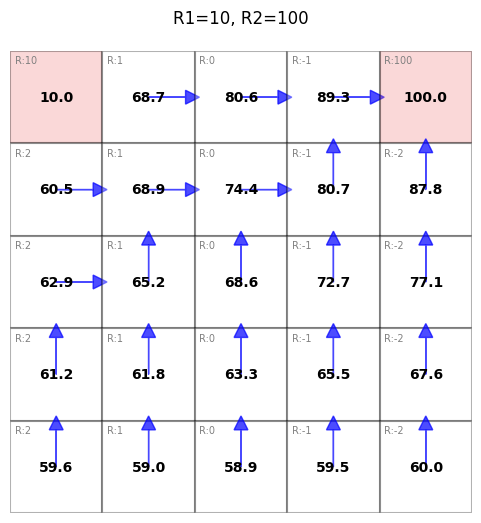

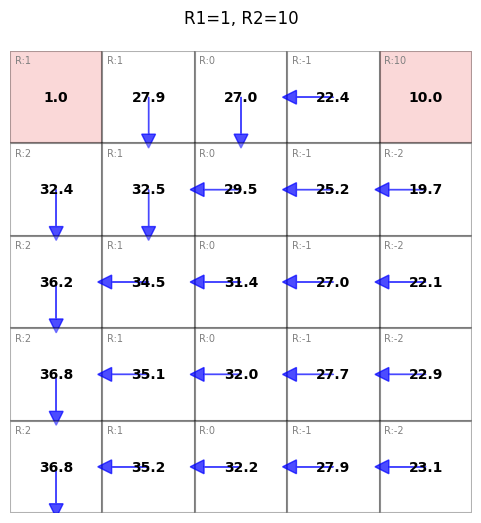

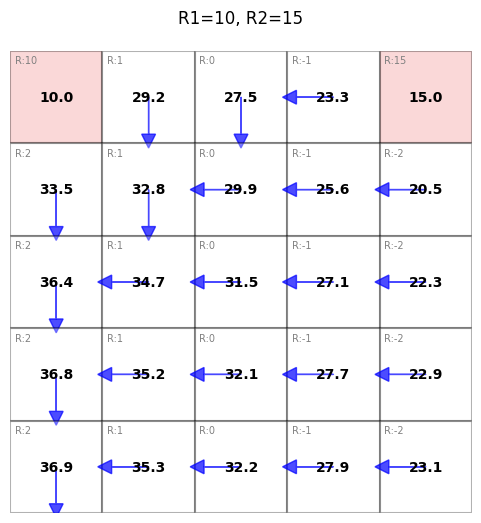

In [309]:
def value_iteration(states, actions, P, R, R1_reward, R2_reward, gamma=gamma):
    # Initialize and Pin Terminal Values
    V = {s: 0.0 for s in states}
    V[R1] = R1_reward
    V[R2] = R2_reward
    
    V_star, Q_star = solve_fixed_point(T_opt, states, initial_V=V, actions=actions, P=P, R=R, gamma=gamma)
    
    policy = {s: max(Q_star[s], key=Q_star[s].get) for s in states if s not in terminal_states}
    return V_star, policy

reward_scenarios = [(100, 110), (10, 100), (1, 10), (10, 15)]

R_static = immediate_reward()

for r1, r2 in reward_scenarios:
    V, pol = value_iteration(states, actions, P, R_static, r1, r2)
    
    plot_gridworld(R_static, V=V, policy=pol, title=f"R1={r1}, R2={r2}", R1_val=r1, R2_val=r2)
    #print(V)
    #print(pol)


## Intuition Behind Optimal Policies for Different Rewards

The agent's behavior is a three-way tug-of-war between **Prize Size**, **Distance**, and **Step Rewards** (which range from **-2** to **+2**).

| Scenario | Prize Ratio | Agent's Logic | Resulting Behavior |
| --- | --- | --- | --- |
| **100 vs 110** | **1 : 1.1** | "Prizes are huge. Step rewards don't matter. I'll take the closest one." | **The Split**: Grid is divided in half. |
| **10 vs 100** | **1 : 10** | "R2 is 10x better. I'll cross the negative-reward 'cold' zone to get that 100." | **The Rush**: Almost all arrows point to **R2**. |
| **1 vs 10** | **1 : 10** | "Prizes are tiny. I get **+2** per step on the left. I'll stay there forever." | **The Farm**: Arrows point to the far-left columns. |
| **10 vs 15** | **1 : 1.5** | "R2 is slightly better, but the **+2** rewards on the left are a better long-term deal." | **The Farm**: Arrows point to the far-left columns. |

### Key Factors

1. **Relative Magnitude**: If the Prize is much larger than the Step Reward, the agent rushes to the goal. If the Prize is small (like 1 or 10), the agent ignores the goal to "farm" the **positive** rewards on the left.
2. **Step Reward Accumulation**: Because $\gamma=0.95$, a consistent **+2** reward is worth more than a one-time **+10** prize if the agent can stay in the grid long enough. Mathematically, the infinite sum of $+2$ rewards discounted by $0.95$ converges to $\frac{2}{1-0.95} = 40$.
3. **Boundary Conditions**: Since terminal values are pinned, they act as "exit doors." If the "exit" pays less than the expected value of staying in the "room" (the left columns), the agent refuses to leave.

### Policy Iteration
Start with an initial policy and iteratively perform:

1. **Policy Evaluation:** Solve 

$$
V_{\pi} = T^{\pi}( V_{\pi})
$$

to compute the value function for the current policy.

2. **Policy Improvement:** Update the policy greedily as

$$
\pi_{\text{new}}(a\mid s) =
\begin{cases}
1, & \text{if } a = \arg\max_{a'} q_{\pi}(s, a')\\[2mm]
0, & \text{otherwise}
\end{cases}
$$

Repeat until the policy stabilizes. The final policy is optimal for the given reward setting.


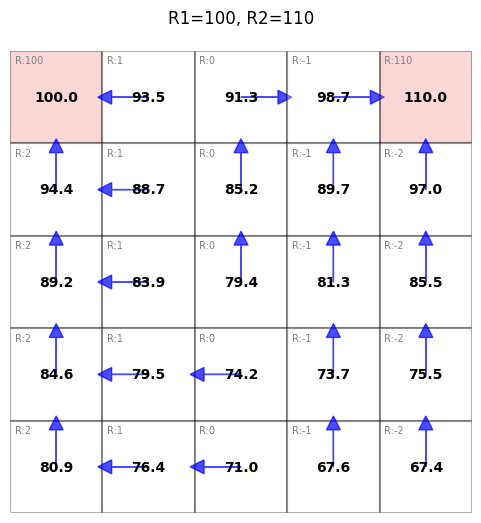

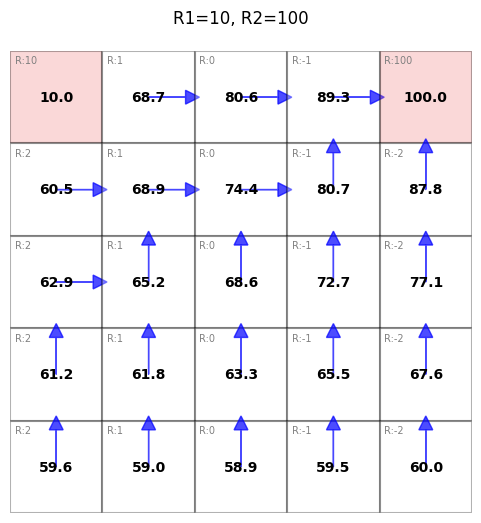

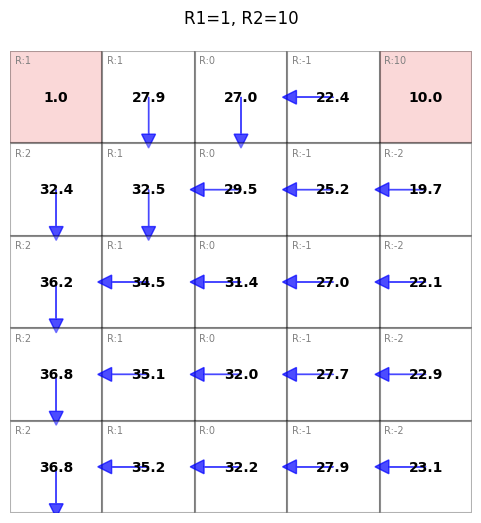

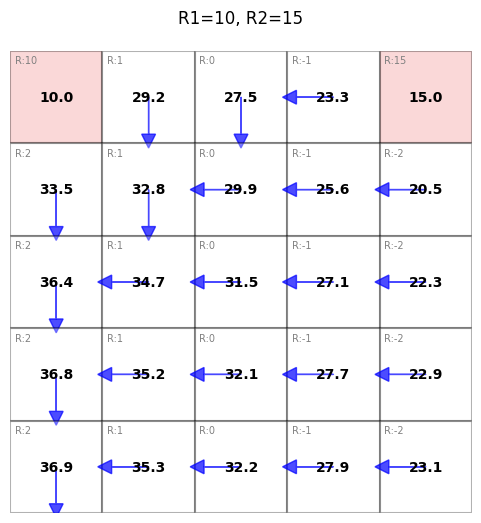

In [310]:
def policy_iteration(states, actions, P, R, R1_reward, R2_reward, gamma=gamma):
    import random
    # 1. Initialize Policy (only for non-terminal states)
    policy = {s: random.choice(actions) for s in states if s not in terminal_states}
    
    # 2. Initialize and Pin Terminal Values (Boundary Conditions)
    V = {s: 0.0 for s in states}
    V[R1] = R1_reward
    V[R2] = R2_reward
    
    while True:
        # Step 1: Policy Evaluation (find fixed point of T_pi)
        V, _ = solve_fixed_point(T_pi, states, initial_V=V, P=P, R=R, policy=policy, gamma=gamma)
        
        # Step 2: Policy Improvement (Greedy update using T_opt)
        _, Q = T_opt(V, states, actions, P, R, gamma)
        new_policy = {s: max(Q[s], key=Q[s].get) for s in states if s not in terminal_states}
        
        # Check for convergence
        if new_policy == policy:
            break
        policy = new_policy
        
    return V, policy

# Prepare static rewards and scenario list
reward_scenarios = [(100, 110), (10, 100), (1, 10), (10, 15)]
R_static = immediate_reward() # Returns dictionary of step rewards only

# Loop through scenarios using Policy Iteration
for r1, r2 in reward_scenarios:
    V, pol = policy_iteration(states, actions, P, R_static, r1, r2, gamma=gamma)
    
    # Plot results
    plot_gridworld(R_static, V=V, policy=pol, title=f"R1={r1}, R2={r2}", R1_val=r1, R2_val=r2)
    #print(V)
    #print(pol)